In [3]:
import string
import pandas as pd
import numpy as np
import nltk
import ssl

from bs4 import BeautifulSoup

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, hamming_loss
from sklearn.metrics import hamming_loss
from sklearn.model_selection import train_test_split

import catboost as ctb
from catboost.utils import eval_metric
from gensim.models import Word2Vec

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gorinenko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/gorinenko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Постановка задачи

В первой части tf_idf_base_line.ipynb мы составили базовый pipeline обучение модели CatBoostClassifier на базе признаков, извлеченных с использованием TfidfVectorizer. В этом документе мы извлечем признаки с использованием модели Word2Vec и сравним метрики моделей в разных случаях. 

# Предобработка текста

In [4]:
file_path = 'data/stackoverflow_posts.csv'
# file_path = 'data/stackexchange_posts.csv'

nrows = 20_000
raw_df = pd.read_csv(file_path)
df = raw_df[~raw_df['Tags'].isna()]

df = df.iloc[:nrows, :]
df.reset_index(inplace=True)
# Всего - 912090

print(f'samples count {df.shape[0]}')

samples count 20000


In [5]:
df.fillna('', inplace=True)

In [6]:
def parse_tags(value):
    tags = value.replace('<', '').split('>')
    return [tag for tag in tags if tag]

    
df["Tags"] = df["Tags"].apply(lambda x: parse_tags(x))

In [7]:
stop_words = set(stopwords.words('russian'))
punctuation = set(string.punctuation)


class TextPreProcessor:
    def __init__(self, tokenizer, stemmer=None, morph=None):
        self.tokenizer = tokenizer
        self.stemmer = stemmer
        self.morph = morph


    def tokenize(self, text: str):      
        text = text.lower()
      
        doc = BeautifulSoup(text, 'lxml')
        text = doc.text
        
        tokens = self.tokenizer.tokenize(text)
        
        words = [word for word in tokens if word not in stop_words and word not in punctuation]
        
        if self.morph:
            words = [self.morph.parse(word)[0].normal_form for word in words]

        if self.stemmer:
            words = [self.stemmer.stem(word) for word in words]

        return words
  
class NltkTokenizer:    
    def tokenize(self, text: str):      
        return list(word_tokenize(text))

In [8]:
def preprocessor(text):
    if not isinstance(text, str):
          return text
      
    tokenizer = TextPreProcessor(tokenizer=NltkTokenizer())    
    words = tokenizer.tokenize(text)
    return words
    
df['Body_cleaned'] = df['Body'].apply(lambda x: preprocessor(x))

/var/folders/g5/8xrz2mg176j1yxttghxsl4gc0000gn/T/ipykernel_14353/1889254982.py:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  doc = BeautifulSoup(text, 'lxml')


In [9]:
df.head(15)

,index,Id,Title,Body,Tags,Body_cleaned
0,0,1,Как из скрипта на Питоне послать письмо с влож...,<p>Нужен простейший пример посылки письма с вл...,"[python, smtp]","[нужен, простейший, пример, посылки, письма, в..."
1,1,1,Как из скрипта на Питоне послать письмо с влож...,<p>Нужен простейший пример посылки письма с вл...,"[python, smtp]","[нужен, простейший, пример, посылки, письма, в..."
2,4,3,Как сохранить и восстановить базу данных Postg...,"<p>Например, имеется пользователь <em>postgres...",[postgresql],"[например, имеется, пользователь, postgres, ба..."
3,5,3,Как сохранить и восстановить базу данных Postg...,"<p>Например, имеется пользователь <em>postgres...",[postgresql],"[например, имеется, пользователь, postgres, ба..."
4,8,5,Как найти файл по имени в папках командой из т...,<p>Какая команда Linux наиболее подходит подоб...,"[linux, файлы]","[команда, linux, наиболее, подходит, подобного..."
5,9,5,Как найти файл по имени в папках командой из т...,<p>Какая команда Linux наиболее подходит подоб...,"[linux, файлы]","[команда, linux, наиболее, подходит, подобного..."
6,12,7,Как работать с svn через HTTP прокси на Ubuntu?,<p>При попытке извлечения кода svn выдает след...,"[http, svn, прокси]","[попытке, извлечения, кода, svn, выдает, следу..."
7,13,7,Как работать с svn через HTTP прокси на Ubuntu?,<p>При попытке извлечения кода svn выдает след...,"[http, svn, прокси]","[попытке, извлечения, кода, svn, выдает, следу..."
8,16,9,Как подсчитать строки в файле из терминала в U...,<p>Какая команда наиболее проста и удобна?</p>,[linux],"[команда, наиболее, проста, удобна]"
9,17,9,Как подсчитать строки в файле из терминала в U...,<p>Какая команда наиболее проста и удобна?</p>,[linux],"[команда, наиболее, проста, удобна]"


In [10]:
multi_label = MultiLabelBinarizer()
Y = multi_label.fit_transform(list(df["Tags"]))

# Feature Engineering

## Word2Vec

Получим векторное представление текстов колонки Body_cleaned с использованием Word2Vec.

In [11]:
w2v_model = Word2Vec(df["Body_cleaned"], vector_size=200, window=5, min_count=5, workers=10)

In [12]:
s = w2v_model.wv.vectors.shape
print(f'Размер словаря {s[0]}')
print(f'Размер признаков {s[1]}')

Размер словаря 21358
Размер признаков 200


Выведем топ 10 наиболее похожих слов для слова 'javascript'

In [13]:
w2v_model.wv.most_similar('принтер', topn=10)

[('клавиш', 0.9715134501457214),
 ('заднего', 0.971503734588623),
 ('наведению', 0.9683551788330078),
 ('пдф', 0.9678186774253845),
 ('просмотра', 0.9665837287902832),
 ('учебника', 0.9665721654891968),
 ('twebbrowser', 0.9660388827323914),
 ('зоны', 0.9657800793647766),
 ('фоновую', 0.9657274484634399),
 ('паттерн', 0.9653744101524353)]

Посмотрим на словарь слов

In [14]:
w2v_model.wv.index_to_key[20:30]

['for',
 'return',
 'вопрос',
 'php',
 'подскажите',
 'div',
 'var',
 'string',
 'void',
 'echo']

Построим расположение слов в двумерном пространстве

In [15]:
from matplotlib import pyplot
from sklearn.decomposition import PCA


def plot_w2v(word_list):
    X = w2v_model.wv[word_list]
    
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    pyplot.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
        
    pyplot.figure(figsize=(15, 15))
    pyplot.show()

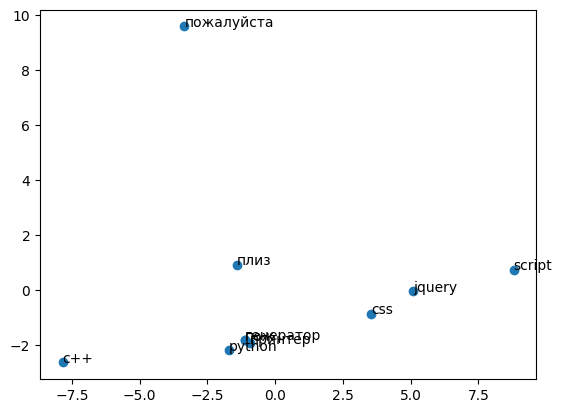

<Figure size 1500x1500 with 0 Axes>

In [16]:
plot_w2v(['jquery', 'script', 'css', 'python', 'c++', 'пожалуйста', 'плиз', 'пож','принтер', 'генератор'])

Ниже представлена функция, которая векторизует предложения методом усреднения векторов его слов.

In [17]:
def get_embedding_w2v(tokens, model):
    if not tokens:
        return []
    
    return model.wv.get_mean_vector(tokens)

# Обучение модели

In [18]:
X_w2v = [] 
for row in df['Body_cleaned']:
    X_w2v.append(get_embedding_w2v(row, w2v_model))

X_w2v = pd.DataFrame(X_w2v)

In [19]:
random_state=42

X_train, X_test, y_train, y_test = train_test_split(X_w2v, Y, test_size=0.1, random_state=random_state, shuffle=True)

In [20]:
from catboost import Pool


device = 'cpu'
train_params = {
    'random_state': random_state, 
    'eval_metric': 'HammingLoss', 
    'task_type': device.upper(), 
    'metric_period': 10, 
    'verbose': 50,
    'iterations': 100,
    'allow_const_label': True,
    # 'logging_level': 'Silent',  
    'loss_function': 'MultiCrossEntropy',
    # 'loss_function': 'MultiLogloss',
    'class_names': multi_label.classes_
}

In [21]:
model = ctb.CatBoostClassifier(**train_params)
model.fit(Pool(X_train, y_train), eval_set=Pool(X_test, y_test), plot=True, use_best_model = True)                

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.176182
0:	learn: 0.0019494	test: 0.0019580	best: 0.0019580 (0)	total: 23.8s	remaining: 39m 14s
50:	learn: 0.0013044	test: 0.0016587	best: 0.0016587 (50)	total: 22m 25s	remaining: 21m 32s
99:	learn: 0.0008308	test: 0.0012497	best: 0.0012497 (99)	total: 46m 48s	remaining: 0us

bestTest = 0.00124974975
bestIteration = 99



## Оценка модели

Оценим метрики scikit learn

In [22]:
preds = model.predict(X_test)
probs = model.predict_proba(X_test)

# Делается предсказание для каждого класса
assert preds.shape[1] == multi_label.classes_.shape[0]
assert probs.shape[1] == multi_label.classes_.shape[0]

In [23]:
preds.shape

(2000, 999)

In [24]:
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, average=None, zero_division=0)
recall = recall_score(y_test, preds, average=None, zero_division=0)
f1 = f1_score(y_test, preds, average=None, zero_division=0)
auc = roc_auc_score(y_test, probs[:,1].reshape(-1, 1), average=None)
hamming = hamming_loss(y_test, preds)


print(f'accuracy: {accuracy}\n')
print(f'precision: {list(precision)}\n')
print(f'recall: {list(recall)}\n')
print(f'f1: {list(f1)}\n')
print(f'auc: {auc}\n')
print(f'hamming: {hamming}\n')

accuracy: 0.2275

precision: [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.9411764705882353, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.9285714285714286, 0.0, 0.7980769230769231, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.8070175438596491, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.9411764705882353, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 

Сравним полученные метрики с метриками пакета catboost.

Средняя точность по всем классам:

In [25]:
accuracy = eval_metric(y_test, preds, 'Accuracy')[0]
print(f'Accuracy: {accuracy}')

Accuracy: 0.2275


Точность предсказания каждого класса в отдельности:

In [26]:
accuracy_per_class = eval_metric(y_test, preds, 'Accuracy:type=PerClass')
for cls, value in zip(multi_label.classes_, accuracy_per_class):
    print(f'Accuracy for class {cls}: {value}')

Accuracy for class .htaccess: 0.9985
Accuracy for class .net: 0.9845
Accuracy for class 1с: 0.9985
Accuracy for class 2d: 1.0
Accuracy for class 3d: 1.0
Accuracy for class 3g: 1.0
Accuracy for class access: 1.0
Accuracy for class access-control: 1.0
Accuracy for class action: 1.0
Accuracy for class actionscript: 0.9975
Accuracy for class actionscript-3: 0.999
Accuracy for class active-directory: 1.0
Accuracy for class active-perl: 1.0
Accuracy for class activex: 1.0
Accuracy for class adapter: 1.0
Accuracy for class addons: 1.0
Accuracy for class ado: 1.0
Accuracy for class ado.net: 1.0
Accuracy for class adobe: 1.0
Accuracy for class adsl: 1.0
Accuracy for class agile: 1.0
Accuracy for class air: 1.0
Accuracy for class ajax: 0.9845
Accuracy for class andengine: 1.0
Accuracy for class android: 0.974
Accuracy for class android-adb: 1.0
Accuracy for class android-layout: 1.0
Accuracy for class android-ndk: 1.0
Accuracy for class android-sdk: 1.0
Accuracy for class android-shared-preferen

Метрики Precision, Recall и F1 также считаются для каждого класса в отдельности:

In [27]:
print('Precision')

values = eval_metric(y_test, preds, 'Precision')
for cls, value in zip(multi_label.classes_, values):
    print(f'class={cls}: {value:.4f}')


Precision
class=.htaccess: 1.0000
class=.net: 1.0000
class=1с: 1.0000
class=2d: 1.0000
class=3d: 1.0000
class=3g: 1.0000
class=access: 1.0000
class=access-control: 1.0000
class=action: 1.0000
class=actionscript: 1.0000
class=actionscript-3: 1.0000
class=active-directory: 1.0000
class=active-perl: 1.0000
class=activex: 1.0000
class=adapter: 1.0000
class=addons: 1.0000
class=ado: 1.0000
class=ado.net: 1.0000
class=adobe: 1.0000
class=adsl: 1.0000
class=agile: 1.0000
class=air: 1.0000
class=ajax: 1.0000
class=andengine: 1.0000
class=android: 0.9412
class=android-adb: 1.0000
class=android-layout: 1.0000
class=android-ndk: 1.0000
class=android-sdk: 1.0000
class=android-shared-preferences: 1.0000
class=android-sources: 1.0000
class=ant: 1.0000
class=apache: 1.0000
class=apache-flex: 1.0000
class=apache-modules: 1.0000
class=apache-poi: 1.0000
class=apache2.2: 1.0000
class=api: 1.0000
class=applet: 1.0000
class=apt-get: 1.0000
class=aptana: 1.0000
class=archive: 1.0000
class=arm: 1.0000
class

In [28]:
print('Recall')

values = eval_metric(y_test, preds, 'Recall')
for cls, value in zip(multi_label.classes_, values):
    print(f'class={cls}: {value:.4f}')

Recall
class=.htaccess: 0.7000
class=.net: 0.0606
class=1с: 0.4000
class=2d: 1.0000
class=3d: 1.0000
class=3g: 1.0000
class=access: 1.0000
class=access-control: 1.0000
class=action: 1.0000
class=actionscript: 0.1667
class=actionscript-3: 0.6000
class=active-directory: 1.0000
class=active-perl: 1.0000
class=activex: 1.0000
class=adapter: 1.0000
class=addons: 1.0000
class=ado: 1.0000
class=ado.net: 1.0000
class=adobe: 1.0000
class=adsl: 1.0000
class=agile: 1.0000
class=air: 1.0000
class=ajax: 0.1389
class=andengine: 1.0000
class=android: 0.2388
class=android-adb: 1.0000
class=android-layout: 1.0000
class=android-ndk: 1.0000
class=android-sdk: 1.0000
class=android-shared-preferences: 1.0000
class=android-sources: 1.0000
class=ant: 1.0000
class=apache: 0.2000
class=apache-flex: 1.0000
class=apache-modules: 1.0000
class=apache-poi: 1.0000
class=apache2.2: 1.0000
class=api: 1.0000
class=applet: 1.0000
class=apt-get: 1.0000
class=aptana: 1.0000
class=archive: 1.0000
class=arm: 1.0000
class=as

In [29]:
print('F1')

values = eval_metric(y_test, preds, 'F1')
for cls, value in zip(multi_label.classes_, values):
    print(f'class={cls}: {value:.4f}')

F1


class=.htaccess: 0.8235
class=.net: 0.1143
class=1с: 0.5714
class=2d: 1.0000
class=3d: 1.0000
class=3g: 1.0000
class=access: 1.0000
class=access-control: 1.0000
class=action: 1.0000
class=actionscript: 0.2857
class=actionscript-3: 0.7500
class=active-directory: 1.0000
class=active-perl: 1.0000
class=activex: 1.0000
class=adapter: 1.0000
class=addons: 1.0000
class=ado: 1.0000
class=ado.net: 1.0000
class=adobe: 1.0000
class=adsl: 1.0000
class=agile: 1.0000
class=air: 1.0000
class=ajax: 0.2439
class=andengine: 1.0000
class=android: 0.3810
class=android-adb: 1.0000
class=android-layout: 1.0000
class=android-ndk: 1.0000
class=android-sdk: 1.0000
class=android-shared-preferences: 1.0000
class=android-sources: 1.0000
class=ant: 1.0000
class=apache: 0.3333
class=apache-flex: 1.0000
class=apache-modules: 1.0000
class=apache-poi: 1.0000
class=apache2.2: 1.0000
class=api: 1.0000
class=applet: 1.0000
class=apt-get: 1.0000
class=aptana: 1.0000
class=archive: 1.0000
class=arm: 1.0000
class=asp: 1.00

HammingLoss, разность единицы и средней точности предсказания каждого класса в отдельности:

In [30]:
hamming = eval_metric(y_test, preds, 'HammingLoss')[0]
print(f'HammingLoss: {hamming:.4f}')
mean_accuracy_per_class = sum(accuracy_per_class) / len(accuracy_per_class)
print(f'MeanAccuracyPerClass: {mean_accuracy_per_class:.4f}')
print(f'HammingLoss + MeanAccuracyPerClass = {hamming + mean_accuracy_per_class}')


HammingLoss: 0.0012
MeanAccuracyPerClass: 0.9988
HammingLoss + MeanAccuracyPerClass = 1.0000000000000009


## Предсказания модели

In [31]:
valid_df = df[df['Tags'].isna()]

In [32]:
import random

valid_df = raw_df[~raw_df['Tags'].isna()]
valid_df.reset_index(inplace=True)


row_num = random.randint(0, valid_df['Body'].shape[0])
text = valid_df['Body'][row_num]

print(f'Текст: \n{text}\n')

X_w2v_val = get_embedding_w2v(preprocessor(text), w2v_model)

preds = model.predict(X_w2v_val)

labels = multi_label.inverse_transform(preds.reshape(1, -1))
print(f'Предсказанные теги: \n{labels}\n')

Текст: 
<p>Есть два DatePickerDialog. Выбранная дата в первом должна стать минимальной датой во втором. 
Сделал это так </p>

<pre><code> private void setInitialDateTime(TextView textView) {

    textView.setText(DateUtils.formatDateTime(getActivity(),
            dateAndTime.getTimeInMillis(),
            DateUtils.FORMAT_SHOW_DATE | DateUtils.FORMAT_SHOW_YEAR
    ));

}
// установка обработчика выбора даты
DatePickerDialog.OnDateSetListener fD=new DatePickerDialog.OnDateSetListener() {
    public void onDateSet(DatePicker view, int year, int monthOfYear, int dayOfMonth) {
        dateAndTime.set(Calendar.YEAR, year);
        dateAndTime.set(Calendar.MONTH, monthOfYear);
        dateAndTime.set(Calendar.DAY_OF_MONTH, dayOfMonth);
        setInitialDateTime(finishDate);
    }
};
DatePickerDialog.OnDateSetListener bD=new DatePickerDialog.OnDateSetListener() {
    public void onDateSet(DatePicker view, int year, int monthOfYear, int dayOfMonth) {

        dateAndTime.set(Calendar.YEAR, y

In [33]:
model.save_model(f"data/w2v_{nrows}")

# Выводы

При использовании Word2Vec разницы во времени обучения модели нет, но модель немного точнее предсказывает метки-теги. Вектора отображают смысл слов, их можно сравнивать, складывать, подсчитывать близость. К недостаткам следует отнести фиксированный размер словаря, однако в отличие от Tfidf, модель Word2Vec можно дообучать при появлении новых слов. При использовании Word2Vec для редких слов получаются неоптимальные эмбеддинги, и слова, имеющие разный корень, обрабатываются моделью по разному. 